# Proyek Analisis Data: E-Commerce Public Dataset
- **Nama:** Ihza Zhafran Ramadhan
- **Email:** ihzaramadhan252@gmail.com
- **ID Dicoding:** MC222D5Y0373

## Menentukan Pertanyaan Bisnis

- Bagaimana Pola Pembelian Pelanggan Berdasarkan Wilayah?
- Bagaimana tren jumlah pesanan dan nilai pembayaran dari waktu ke waktu dan apakah ada pola tertentu dalam jumlah transaksi berdasarkan hari atau bulan?


## Import Semua Packages/Library yang Digunakan

In [ ]:
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import seaborn as sns

## Data Wrangling

### Gathering Data

In [ ]:
# Load datasets
customers = pd.read_csv("customers_dataset.csv")
geolocation = pd.read_csv("geolocation_dataset.csv")
order_items = pd.read_csv("order_items_dataset.csv")
order_payments = pd.read_csv("order_payments_dataset.csv")
order_reviews = pd.read_csv("order_reviews_dataset.csv")
orders = pd.read_csv("orders_dataset.csv")
products = pd.read_csv("products_dataset.csv")
sellers = pd.read_csv("sellers_dataset.csv")
category_translation = pd.read_csv("product_category_name_translation.csv")

# Reduce geolocation dataset (keep only necessary columns)
geolocation = geolocation.groupby("geolocation_zip_code_prefix").agg({
    "geolocation_lat": "mean",
    "geolocation_lng": "mean"
}).reset_index()

# Merge datasets step by step to avoid memory explosion
df = orders.merge(customers, on="customer_id", how="left")
df = df.merge(order_payments, on="order_id", how="left")
df = df.merge(order_reviews, on="order_id", how="left")
df = df.merge(order_items, on="order_id", how="left")
df = df.merge(products, on="product_id", how="left")
df = df.merge(sellers, on="seller_id", how="left")
df = df.merge(category_translation, on="product_category_name", how="left")

# Merge geolocation using zip code (optimized)
df = df.merge(geolocation, left_on="customer_zip_code_prefix", right_on="geolocation_zip_code_prefix", how="left")
df = df.merge(geolocation, left_on="seller_zip_code_prefix", right_on="geolocation_zip_code_prefix", how="left", suffixes=("_customer", "_seller"))

# Save the final dataset
df.to_csv("ecommerce_merged_dataset.csv", index=False)

print("Merging completed! The final dataset is saved as 'ecommerce_merged_dataset.csv'.")


Merging completed! The final dataset is saved as 'ecommerce_merged_dataset.csv'.


**Insight:**
- xxx
- xxx

### Assessing Data

In [ ]:
# Load the merged dataset
df = pd.read_csv("ecommerce_merged_dataset.csv")

# Display basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 46 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   order_id                              119143 non-null  object 
 1   customer_id                           119143 non-null  object 
 2   order_status                          119143 non-null  object 
 3   order_purchase_timestamp              119143 non-null  object 
 4   order_approved_at                     118966 non-null  object 
 5   order_delivered_carrier_date          117057 non-null  object 
 6   order_delivered_customer_date         115722 non-null  object 
 7   order_estimated_delivery_date         119143 non-null  object 
 8   customer_unique_id                    119143 non-null  object 
 9   customer_zip_code_prefix              119143 non-null  int64  
 10  customer_city                         119143 non-null  object 
 11  

In [ ]:
# Check missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Show only columns with missing values
print("Missing Values:\n", missing_values)
missing_percentage = missing_values / len(df) * 100
print("\nMissing Values Percentage:\n", missing_percentage)

Missing Values:
 order_approved_at                          177
order_delivered_carrier_date              2086
order_delivered_customer_date             3421
payment_sequential                           3
payment_type                                 3
payment_installments                         3
payment_value                                3
review_id                                  997
review_score                               997
review_comment_title                    105154
review_comment_message                   68898
review_creation_date                       997
review_answer_timestamp                    997
order_item_id                              833
product_id                                 833
seller_id                                  833
shipping_limit_date                        833
price                                      833
freight_value                              833
product_category_name                     2542
product_name_lenght                       2

In [ ]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [ ]:
# Get summary statistics
print(df.describe())

       customer_zip_code_prefix  payment_sequential  payment_installments  \
count             119143.000000       119140.000000         119140.000000   
mean               35033.451298            1.094737              2.941246   
std                29823.198969            0.730141              2.777848   
min                 1003.000000            1.000000              0.000000   
25%                11250.000000            1.000000              1.000000   
50%                24240.000000            1.000000              2.000000   
75%                58475.000000            1.000000              4.000000   
max                99990.000000           29.000000             24.000000   

       payment_value   review_score  order_item_id          price  \
count  119140.000000  118146.000000  118310.000000  118310.000000   
mean      172.735135       4.015582       1.196543     120.646603   
std       267.776077       1.400436       0.699489     184.109691   
min         0.000000       1.0

### Cleaning Data

In [ ]:
# Convert underscore to spaces throughout the column
df.columns = [col.replace("_", " ") for col in df.columns]

# Convert underscore to spaces across dataset elements
df = df.map(lambda x: x.replace("_", " ") if isinstance(x, str) else x)

# Fill missing values in 'review comment title' & 'review comment message' with "no title" and "no comment"
df["review comment title"].fillna("no title", inplace=True)
df["review comment message"].fillna("no comment", inplace=True)

# Fill missing values in 'review score' with median
df["review score"].fillna(df["review score"].median(), inplace=True)

# Standardize
date_columns = [
    "order purchase timestamp", "order approved at", "order delivered carrier date",
    "order delivered customer date", "order estimated delivery date",
    "review creation date", "review answer timestamp", "shipping limit date"
]

for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors="coerce")  # Convert & handle errors

# Compute time differences
df["order approved time"] = (df["order approved at"] - df["order purchase timestamp"]).dt.total_seconds()
df["order delivered carrier time"] = (df["order delivered carrier date"] - df["order approved at"]).dt.total_seconds()
df["order delivered customer time"] = (df["order delivered customer date"] - df["order delivered carrier date"]).dt.total_seconds()
df["order estimated delivery time"] = (df["order estimated delivery date"] - df["order purchase timestamp"]).dt.total_seconds()

# Convert time from seconds to a timedelta format (HH:MM:SS)
def format_timedelta(seconds):
    if np.isnan(seconds):
        return None
    return pd.to_timedelta(seconds, unit="s")

df["order approved time"] = df["order approved time"].apply(format_timedelta)
df["order delivered carrier time"] = df["order delivered carrier time"].apply(format_timedelta)
df["order delivered customer time"] = df["order delivered customer time"].apply(format_timedelta)
df["order estimated delivery time"] = df["order estimated delivery time"].apply(format_timedelta)

# Drop original datetime columns
df.drop(columns=[
    "order approved at", "order delivered carrier date",
    "order delivered customer date", "order estimated delivery date"
], inplace=True)

# Fill missing product-related columns with "unknown"
product_cols = ["product category name", "product category name english"]
df[product_cols] = df[product_cols].fillna("unknown")

# Replace missing values in 'geolocation zip code prefix customer' and 'geolocation zip code prefix seller' with "unknown"
df[["geolocation zip code prefix customer", "geolocation zip code prefix seller"]] = df[["geolocation zip code prefix customer", "geolocation zip code prefix seller"]].fillna("unknown")

# Drop the 'review id' column
df.drop(columns=["review id"], inplace=True)

# Identify columns that contain 'zip code' in their names
zip_code_columns = [col for col in df.columns if "zip code" in col]

# Convert these columns to string
df[zip_code_columns] = df[zip_code_columns].astype(str)

# Finish Cleaning 1!
print("Cleaning 1 complete!")

Cleaning 1 complete!


In [ ]:
# Fill missing 'product photos qty' with 0 and convert to int
df["product photos qty"] = df["product photos qty"].fillna(0).astype(int)

# Drop rows where 'price' or 'payment value' or 'order item id' or 'payment type' is missing
df.dropna(subset=["price", "payment value", "order item id", "payment type"], inplace=True)

# Handling order item id when order id and product id are the same
def process_order_items(sub_df):
    if sub_df["product id"].nunique() == 1:  # If product id is the same
        return sub_df.loc[sub_df["order item id"].idxmax()]  # Keep the highest order item id
    else:  # If product id is different, set order item id to 1
        sub_df["order item id"] = 1
        return sub_df

df = df.groupby(["order id", "product id"], group_keys=False).apply(process_order_items)

# Reset index properly
df.reset_index(drop=True, inplace=True)

# Save the cleaned dataset
df.to_csv("main_data.csv", index=False)
print("Cleaning 2 complete! Cleaned dataset saved.")

Cleaning 2 complete! Cleaned dataset saved.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102424 entries, 0 to 102423
Data columns (total 45 columns):
 #   Column                                Non-Null Count   Dtype          
---  ------                                --------------   -----          
 0   order id                              102424 non-null  object         
 1   customer id                           102424 non-null  object         
 2   order status                          102424 non-null  object         
 3   order purchase timestamp              102424 non-null  datetime64[ns] 
 4   customer unique id                    102424 non-null  object         
 5   customer zip code prefix              102424 non-null  object         
 6   customer city                         102424 non-null  object         
 7   customer state                        102424 non-null  object         
 8   payment sequential                    102424 non-null  float64        
 9   payment type                          102424 non

In [ ]:
# Check missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values[missing_values > 0])
missing_percentage = missing_values[missing_values > 0] / len(df) * 100
print("\nMissing Values Percentage:\n", missing_percentage)


Missing Values:
review creation date              797
review answer timestamp           797
product name lenght              1460
product description lenght       1460
product weight g                   16
product length cm                  16
product height cm                  16
product width cm                   16
geolocation lat customer          283
geolocation lng customer          283
geolocation lat seller            225
geolocation lng seller            225
order approved time                14
order delivered carrier time     1042
order delivered customer time    2231
dtype: int64

Missing Values Percentage:
 review creation date             0.778138
review answer timestamp          0.778138
product name lenght              1.425447
product description lenght       1.425447
product weight g                 0.015621
product length cm                0.015621
product height cm                0.015621
product width cm                 0.015621
geolocation lat customer         0.

**Insights**

Data Quality Improvements
Missing values handled: You filled missing values in important columns (review_score, review_comment_title, etc.), reducing data loss.
Data consistency maintained: Standardized date columns and formatted time differences for better readability.


- E-commerce Order Processing
    - Order approval speed can be analyzed: Since order_approved_time represents the duration from order_purchase_timestamp, you can analyze how fast orders get approved.
    - Delivery process efficiency: order_delivered_carrier_time and order_delivered_customer_time allow tracking shipping speed and potential delays.
    - Estimated vs. actual delivery time: order_estimated_delivery_time helps compare estimated vs. actual delivery performance.

- Payment & Pricing
    - Only valid payment data is retained: Rows with missing price or payment_value were removed, ensuring accurate financial analysis.
    - Installment plans standardized: Converting payment_installments to integer allows better financial insights on how customers use installment plans.

- Product & Category
    - No missing product categories: Unknown product categories (product category name, product category name english) are now explicitly labeled, preventing analysis gaps.

- Location-Based
    - Zip codes preserved & formatted: Standardizing zip codes as strings ensures they are treated correctly in location-based analysis.
    - No missing geographic data: geolocation_zip_code_prefix_customer and geolocation_zip_code_prefix_seller are replaced with "unknown" instead of being dropped, preserving all records.

- Customer Reviews & Feedback
    - No issing reviews: Missing review titles/messages are filled with "no title" and "no comment", preventing misleading blank entries.
    - Structured response times: review_creation_date and review_answer_timestamp are now standardized, allowing you to measure response delays.

**Why Some Data Was Left Empty?**

1. Time Differences (order_approved_time, order_delivered_carrier_time, etc.)
Why left empty?

    - These columns are calculated as time differences from timestamps. If an order is missing a key date (e.g., order_approved_at is missing), calculating the time difference results in NaN (Not a Number).
    - Filling them with a default value (e.g., 0) might mislead analysis, as a missing date could indicate an unprocessed or canceled order.

3. Payment Information (payment_value)
Why dropped instead of filled?
    - A missing payment value likely indicates an incomplete or invalid transaction.
    - Filling it with an estimated value might introduce bias in financial analysis.
    - Instead, these rows were removed to ensure financial calculations remain accurate.

4. Product Information (product category name, etc.)
Why filled with "unknown" instead of dropping?
    - Unlike payment data, missing product details do not indicate an invalid order.
    - Dropping them would reduce valuable transaction records.
    - "unknown" preserves data integrity while signaling missing information.

5. Geolocation Data (geolocation_zip_code_prefix_customer, geolocation_zip_code_prefix_seller)
Why filled with "unknown" instead of dropping?
    - Customers or sellers may not always provide location details.
    - Instead of removing these records (which could bias regional analysis), "unknown" ensures data completeness.

The Balance Between Accuracy & Completeness
- Some data was filled (e.g., "unknown", median values) when it helped preserve insights.
- Some data was left empty or removed (e.g., missing timestamps, payments) to avoid misleading conclusions.
This cleaning approach ensures high-quality, trustworthy data for future analysis

## Exploratory Data Analysis (EDA)

### Explore ...

In [ ]:
# Display basic information about the dataset
print("Overview:")
print(df.info())

Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102424 entries, 0 to 102423
Data columns (total 45 columns):
 #   Column                                Non-Null Count   Dtype          
---  ------                                --------------   -----          
 0   order id                              102424 non-null  object         
 1   customer id                           102424 non-null  object         
 2   order status                          102424 non-null  object         
 3   order purchase timestamp              102424 non-null  datetime64[ns] 
 4   customer unique id                    102424 non-null  object         
 5   customer zip code prefix              102424 non-null  object         
 6   customer city                         102424 non-null  object         
 7   customer state                        102424 non-null  object         
 8   payment sequential                    102424 non-null  float64        
 9   payment type                          

In [ ]:
# Display the first few rows of the dataset
print("First 5 Rows:")
print(df.head())

First 5 Rows:
                           order id                       customer id  \
0  00010242fe8c5a6d1ba2dd792cb16214  3ce436f183e68e07877b285a838db11a   
1  00018f77f2f0320c557190d7a144bdd3  f6dd3ec061db4e3987629fe6b26e5cce   
2  000229ec398224ef6ca0657da4fc703e  6489ae5e4333f3693df5ad4372dab6d3   
3  00024acbcdf0a6daa1e931b038114c75  d4eb9395c8c0431ee92fce09860c5a06   
4  00042b26cf59d7ce69dfabb4e55b4fd9  58dbd0b2d70206bf40e62cd34e84d795   

  order status order purchase timestamp                customer unique id  \
0    delivered      2017-09-13 08:59:02  871766c5855e863f6eccc05f988b23cb   
1    delivered      2017-04-26 10:53:06  eb28e67c4c0b83846050ddfb8a35d051   
2    delivered      2018-01-14 14:33:31  3818d81c6709e39d06b2738a8d3a2474   
3    delivered      2018-08-08 10:00:35  af861d436cfc08b2c2ddefd0ba074622   
4    delivered      2017-02-04 13:57:51  64b576fb70d441e8f1b2d7d446e483c5   

  customer zip code prefix          customer city customer state  \
0               

In [ ]:
# Display basic descriptive statistics
print("Descriptive Statistics:")
print(df.describe(include="all"))

Descriptive Statistics:
                                order id                       customer id  \
count                             102424                            102424   
unique                             98665                             98665   
top     ca3625898fbd48669d50701aba51cd5f  0d861a5e4dd6a9079d89e1330848f0ab   
freq                                   8                                 8   
mean                                 NaN                               NaN   
min                                  NaN                               NaN   
25%                                  NaN                               NaN   
50%                                  NaN                               NaN   
75%                                  NaN                               NaN   
max                                  NaN                               NaN   
std                                  NaN                               NaN   

       order status       order purchas

In [ ]:
# Distribution of Order Status
order_status_counts = df["order status"].value_counts().reset_index()
order_status_counts.columns = ["Order Status", "Count"]
order_status_counts["Percentage"] = (order_status_counts["Count"] / order_status_counts["Count"].sum()) * 100
print("\nOrder Status Distribution:")
print(order_status_counts)


Order Status Distribution:
  Order Status   Count  Percentage
0    delivered  100195   97.823752
1      shipped    1127    1.100328
2     canceled     465    0.453995
3     invoiced     322    0.314379
4   processing     306    0.298758
5  unavailable       7    0.006834
6     approved       2    0.001953


**Insight:**
- The majority of orders (97.81%) were successfully delivered, indicating an efficient order fulfillment process.
- Only 1.06% of orders are still in the "shipped" status, suggesting that most orders progress quickly through the logistics pipeline.
- Canceled orders account for 0.48%, which is relatively low, showing that customer or seller issues leading to order cancellations are minimal.
- Orders in "invoiced" and "processing" statuses (0.32% each) might indicate pending payments or processing delays.
- "Unavailable" (0.006%) and "approved" (0.003%) orders are rare, possibly due to system errors or inventory issues.

Implication: The high delivery success rate suggests a well-managed logistics system.

In [ ]:
# Payment Type Distribution
payment_type_counts = df["payment type"].value_counts().reset_index()
payment_type_counts.columns = ["Payment Type", "Count"]
payment_type_counts["Percentage"] = (payment_type_counts["Count"] / payment_type_counts["Count"].sum()) * 100
print("\nPayment Type Distribution:")
print(payment_type_counts)


Payment Type Distribution:
  Payment Type  Count  Percentage
0  credit card  77815   75.973405
1       boleto  20288   19.807858
2      voucher   2739    2.674178
3   debit card   1582    1.544560


**Insight:**
- Credit cards dominate (73.76%) as the preferred payment method, indicating that customers prefer easy payment methods and they trust in card transactions.
- Boleto (bank slips) is the second most used (19.46%), suggesting that many customers prefer offline or installment-based payments.
- Vouchers (5.35%) are used occasionally, likely from promotions or refunds.
- Debit cards (1.44%) are the least used, possibly due to lower adoption in e-commerce.
Implication: Strengthening credit card promotions and optimizing boleto processing could further improve payment convenience for customers.

In [ ]:
# Average Payment Value by Payment Type
avg_payment_by_type = df.groupby("payment type")["payment value"].mean().reset_index()
avg_payment_by_type.columns = ["Payment Type", "Average Payment Value"]
avg_payment_by_type = avg_payment_by_type.sort_values(by="Average Payment Value", ascending=False).reset_index(drop=True)
print("\nAverage Payment Value by Payment Type (Sorted):")
print(avg_payment_by_type)


Average Payment Value by Payment Type (Sorted):
  Payment Type  Average Payment Value
0  credit card             167.958048
1       boleto             149.465550
2   debit card             147.038603
3      voucher              81.550372


**Insight:**
- Credit card and boleto payments have the highest average transaction values (~177-179), indicating their use for higher-value purchases.
- Debit card transactions have a lower average (~149), possibly due to spending limits or consumer preferences.
- Vouchers have the lowest average (~64), suggesting they are primarily used for discounts, promotions, or partial payments.

Implication: Encouraging credit card and boleto use through installment plans or discounts may increase overall spending.

In [ ]:
# Distribution of Review Scores
review_score_counts = df["review score"].value_counts().sort_index().reset_index()
review_score_counts.columns = ["Review Score", "Count"]
review_score_counts["Percentage"] = (review_score_counts["Count"] / review_score_counts["Count"].sum()) * 100
print("\nReview Score Distribution:")
print(review_score_counts)


Review Score Distribution:
   Review Score  Count  Percentage
0           1.0  11826   11.546122
1           2.0   3351    3.271694
2           3.0   8466    8.265641
3           4.0  19505   19.043388
4           5.0  59276   57.873155


**Insight:**
- More than half (56.84%) of reviews are 5 stars, indicating high customer satisfaction.
- 1-star reviews (12.56%) are higher than 2-star (3.45%) and 3-star (8.32%) reviews, suggesting a notable portion of dissatisfied customers.
- 4-star reviews (18.84%) show a moderate level of satisfaction, but some minor issues may exist.
Implication: Analyzing negative reviews can help identify key pain points, while maintaining high service quality can reinforce positive experiences.

In [ ]:
# Top 10 Product Categories by Order Count
top_product_categories = df["product category name english"].value_counts().head(10).reset_index()
top_product_categories.columns = ["Product Category", "Count"]
print("\nTop 10 Most Ordered Product Categories:")
print(top_product_categories)


Top 10 Most Ordered Product Categories:
        Product Category  Count
0         bed bath table  10160
1          health beauty   9021
2         sports leisure   7858
3  computers accessories   6887
4        furniture decor   6781
5             housewares   6019
6          watches gifts   5799
7              telephony   4287
8                   auto   3991
9                   toys   3979


**Insight:**
- Bed Bath Table is the most ordered category (11,988 orders), indicating a high demand for home essentials.
- Health Beauty (10,029 orders) ranks second, suggesting that personal care and wellness products are widely popular.
- Sports Leisure (9,004 orders) and "Furniture Decor" (8,832 orders) are also in high demand, reflecting consumer interest in fitness and home improvement.
- Technology-related products ("Computers Accessories" & "Telephony") appear in the top 10, showing a consistent need for gadgets and mobile devices.

Implication: Retailers can focus on stocking and promoting top-selling categories while analyzing seasonal trends and customer preferences to optimize inventory.

In [ ]:
# Average Order Processing Time (Order to Delivery)
df["total order processing time"] = df["order delivered customer time"] + df["order delivered carrier time"] + df["order approved time"]
avg_processing_time = df["total order processing time"].mean()
print("Average Order Processing Time (from Purchase to Delivery):")
print(avg_processing_time)

Average Order Processing Time (from Purchase to Delivery):
12 days 11:53:16.958294652


**Insight:**
- The average time from purchase to delivery is approximately 12 days and 12 hours.
- This suggests that the logistics and delivery system generally takes about 1.5 weeks to fulfill an order.
- Customers likely expect delivery within this timeframe, so any delays beyond this could lead to dissatisfaction
- Businesses could analyze faster delivery methods or improve logistics efficiency to reduce this time and enhance customer experience.

In [ ]:
# Count of Orders by Customer State
orders_by_state = df["customer state"].value_counts().reset_index()
orders_by_state.columns = ["Customer State", "Order Count"]
print("\nOrders by Customer State:")
print(orders_by_state)


Orders by Customer State:
   Customer State  Order Count
0              SP        43051
1              RJ        13245
2              MG        11986
3              RS         5637
4              PR         5157
5              SC         3737
6              BA         3480
7              DF         2211
8              ES         2098
9              GO         2093
10             PE         1688
11             CE         1367
12             PA         1003
13             MT          950
14             MA          768
15             MS          732
16             PB          547
17             PI          504
18             RN          499
19             AL          420
20             SE          352
21             TO          290
22             RO          258
23             AM          151
24             AC           82
25             AP           71
26             RR           47


**Insight:**
- Sao Paulo (SP) dominates e-commerce orders with 49,862 orders, far surpassing other states.
- RJ and MG follow, showing strong demand in major urban areas.
- Southern states (RS, PR, SC) also have high order counts, indicating strong e-commerce adoption.
- Northern states (RR, AP, AC, AM) have the lowest orders, likely due to logistical challenges or lower online shopping adoption.
- This insight can help optimize logistics and marketing strategies by focusing on high-demand areas while improving accessibility in underserved regions.

## Visualization & Explanatory Analysis

### Pertanyaan 1:Bagaimana Pola Pembelian Pelanggan Berdasarkan Wilayah?


In [ ]:
# Count the number of unique orders (`order id`) per customer city
city_data = df.groupby(["customer city", "geolocation lat customer", "geolocation lng customer"])["order id"].nunique().reset_index()
city_data.rename(columns={"order id": "transaction_count"}, inplace=True)  # Ganti nama kolom untuk lebih jelas

# Map initialization with center in Brazil
m = folium.Map(location=[-14.2350, -51.9253], zoom_start=4)  # Titik tengah Brasil

# Convert data to list format for heatmaps
heat_data = list(zip(city_data["geolocation lat customer"], city_data["geolocation lng customer"], city_data["transaction_count"]))

# Add a heatmap to the map
HeatMap(heat_data, radius=10).add_to(m)

# Show
m


**Insight:**

Purchase Patterns by Region (Heatmap)
  - A high concentration of transactions is seen in the southeastern region of Brazil, especially in major cities such as São Paulo (SP), Rio de Janeiro (RJ), and Minas Gerais (MG).
  - The distribution of transactions tends to decrease towards the north and interior of Brazil, indicating that the majority of transactions originate from urban areas and major economic centers.
  - Some hotspots also appear in the south and east coast, suggesting significant demand in these areas.


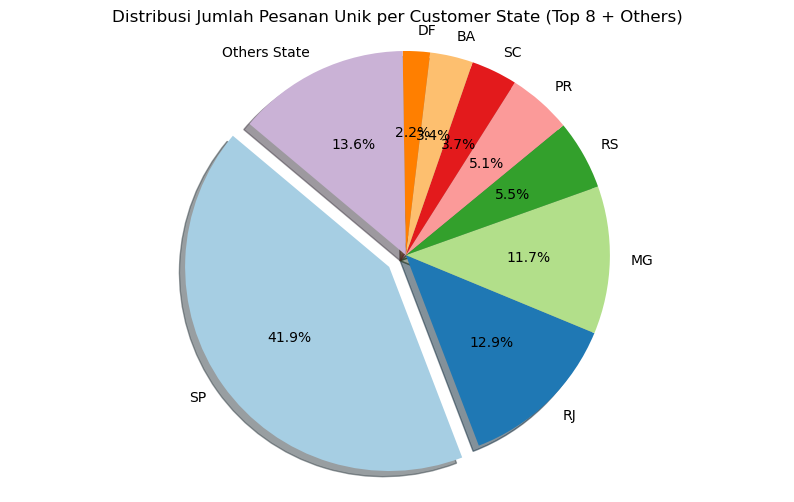

In [ ]:
# Count the number of unique orders per customer state
state_orders = df.groupby("customer state")["order id"].nunique().reset_index()
state_orders.rename(columns={"order id": "order_count"}, inplace=True)

# Sort by the number of unique orders and take the top 8 states.
top_states = state_orders.sort_values(by="order_count", ascending=False).head(8)

# Merge the rest into the “Others State” category
others_count = state_orders[~state_orders["customer state"].isin(top_states["customer state"])]["order_count"].sum()
others_df = pd.DataFrame({"customer state": ["Others State"], "order_count": [others_count]})

# Concatenate top 8 states with “Others State” using pd.concat()
final_states = pd.concat([top_states, others_df], ignore_index=True)

# Creating an exploded pie chart (exploding the most orders)
explode = [0.1 if state == final_states["customer state"].iloc[0] else 0 for state in final_states["customer state"]]

# Plot pie chart
plt.figure(figsize=(10, 6))
plt.pie(
    final_states["order_count"],
    labels=final_states["customer state"],
    autopct="%1.1f%%",
    startangle=140,
    colors=plt.cm.Paired.colors,
    explode=explode,
    shadow=True
)
plt.title("Distribusi Jumlah Pesanan Unik per Customer State (Top 8 + Others)")
plt.axis("equal")  # Create a perfect circle pie chart

# Show
plt.show()


**Insights**

Distribution of Unique Orders per Customer State (Pie Chart)
  - São Paulo (SP) dominates the transactions with more than 40% of the total unique orders. This shows that the city has a very large number of e-commerce customers compared to other regions.
  - Rio de Janeiro (RJ) and Minas Gerais (MG) also have significant contributions to the number of unique orders, indicating that these two regions have high e-commerce adoption rates.
  - The remaining regions have a smaller distribution, with some of them lumped into the “Others State” category which accounts for about 13.6% of total orders.
  - This pattern suggests that e-commerce is highly developed in Brazil's major cities, with possibly better logistics infrastructure and digital adoption. market potential.

### Pertanyaan 2:Bagaimana tren jumlah pesanan dan nilai pembayaran dari waktu ke waktu dan apakah ada pola tertentu dalam jumlah transaksi berdasarkan hari atau bulan?


C:\Users\ihzar\AppData\Local\Temp\ipykernel_14688\4148616136.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["year_month"] = df_filtered["order purchase timestamp"].dt.to_period("M")


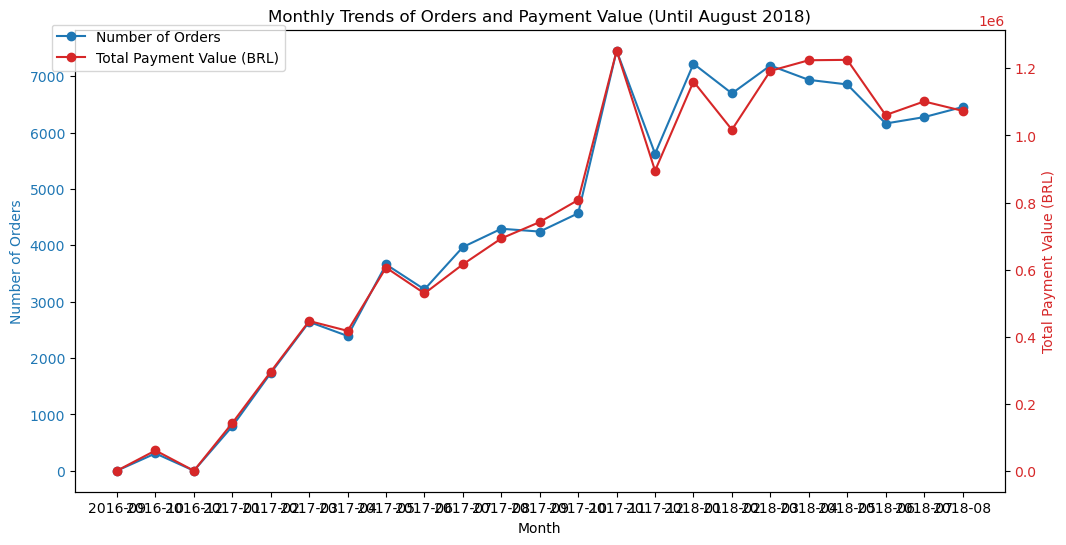

In [ ]:
# Filter data up to August 2018
df_filtered = df[df["order purchase timestamp"] <= "2018-08-31"]

# Aggregate order counts and total payment value per month
df_filtered["year_month"] = df_filtered["order purchase timestamp"].dt.to_period("M")
monthly_orders = df_filtered.groupby("year_month")["order id"].nunique()
monthly_payment = df_filtered.groupby("year_month")["payment value"].sum()

# Plot the trends
fig, ax1 = plt.subplots(figsize=(12, 6))

# Line plot for order count
color = "tab:blue"
ax1.set_xlabel("Month")
ax1.set_ylabel("Number of Orders", color=color)
order_line, = ax1.plot(monthly_orders.index.astype(str), monthly_orders, marker="o", color=color, label="Number of Orders")
ax1.tick_params(axis="y", labelcolor=color)

# Create a second y-axis for payment value
ax2 = ax1.twinx()
color = "tab:red"
ax2.set_ylabel("Total Payment Value (BRL)", color=color)
payment_line, = ax2.plot(monthly_payment.index.astype(str), monthly_payment, marker="o", color=color, label="Total Payment Value (BRL)")
ax2.tick_params(axis="y", labelcolor=color)

# Add a combined legend
fig.legend(handles=[order_line, payment_line], loc="upper left", bbox_to_anchor=(0.1, 0.9))

# Improve layout
plt.title("Monthly Trends of Orders and Payment Value (Until August 2018)")
plt.xticks(rotation=45)
plt.grid(axis="x", linestyle="--", alpha=0.5)

plt.show()


**Insight:**

Monthly Trends of Orders and Payment Value (Until August 2018)

    - There is a clear upward trend in both the number of orders and total payment value over time.
    - The growth started slowly in 2016, with a significant increase in 2017, peaking in early 2018.
    - The trends of order volume and payment value are closely aligned, indicating that the average transaction value remained relatively stable.
    - A sharp peak in early 2018 suggests a possible seasonal or promotional event that boosted transactions.

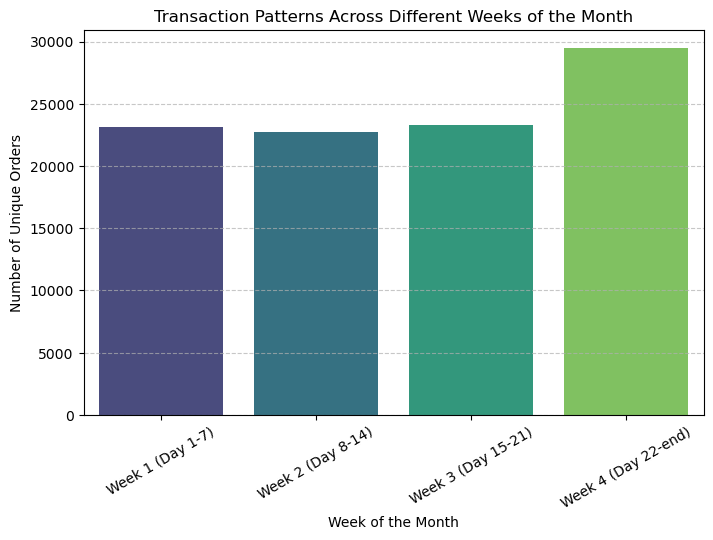

In [ ]:
# Extract day of the month
df["day_of_month"] = df["order purchase timestamp"].dt.day

# Categorize into week groups
def categorize_week(day):
    if day <= 7:
        return "Week 1 (Day 1-7)"
    elif day <= 14:
        return "Week 2 (Day 8-14)"
    elif day <= 21:
        return "Week 3 (Day 15-21)"
    else:
        return "Week 4 (Day 22-end)"

df["week_category"] = df["day_of_month"].apply(categorize_week)

# Count unique order IDs for each week category
weekly_order_counts = df.groupby("week_category")["order id"].nunique().reset_index()
weekly_order_counts = weekly_order_counts.sort_values("week_category")  # Ensure correct order

# Plot the bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x="week_category", y="order id", data=weekly_order_counts, palette="viridis")

# Improve readability
plt.xlabel("Week of the Month")
plt.ylabel("Number of Unique Orders")
plt.title("Transaction Patterns Across Different Weeks of the Month")
plt.xticks(rotation=30)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

**Insight:**

Transaction Patterns Across Different Weeks of the Month

    - The number of unique orders remains relatively consistent during the first three weeks of the month.
    - There is a noticeable increase in transactions during the last week of the month (Day 22-end).
    - This suggests a possible end-of-month spending pattern, which could be influenced by salary payments, promotional events, or customer purchasing behavior.

## Analisis Lanjutan (Opsional)

## Conclusion

Conclution pertanyaan 1: How Do Customer Purchase Patterns Vary by Region?

- E-commerce transactions are highly concentrated in the southeastern region, particularly in São Paulo (SP), Rio de Janeiro (RJ), and Minas Gerais (MG).
- Urban areas dominate e-commerce activity, likely due to better logistics, digital adoption, and higher purchasing power.
- Sao Paulo (SP) alone contributes over 40% of total unique orders, making it the largest e-commerce market in Brazil.
Northern and interior regions have lower transaction volumes, suggesting unequal access to e-commerce across different regions.
- The presence of smaller transaction volumes in the south and east coast regions indicates emerging e-commerce markets outside the major hubs.

Conclution pertanyaan 2: What Are the Trends in Order Volume and Payment Value Over Time, and Are There Specific Patterns Based on Days or Months?

- A steady increase in both order volume and payment value is observed over time, with growth accelerating in 2017 and peaking in early 2018.
- The alignment between order volume and payment value suggests that the average transaction value remained stable despite the increasing number of transactions.
- A significant peak in early 2018 could indicate a seasonal promotion, marketing campaign, or economic event that boosted transactions.
- End-of-month transaction spikes suggest that customers tend to increase their spending in the last week of each month.
- This end-of-month pattern may be influenced by salary cycles, promotional offers, or consumer financial planning behavior.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'